In [2]:
import os
import cv2
import sys
import torch
from model import UNet
import numpy as np
from torch import nn
from os import listdir
from seq2seq_parts import *
from os.path import isfile, isdir
from model import Encoder, Decoder
import matplotlib.pyplot as plt
from convlstm2d import ConvLSTMCell
# from data_preprosess import get_clean_data
from torch.optim import Adam, RMSprop, SGD

In [3]:
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'data/train')

images_paths = [os.path.join(data_dir, f) for f in listdir(data_dir) if isfile(os.path.join(data_dir, f))]

In [4]:
IMAGES_WIDTH = 256
IMAGES_HEIGHT = 256
IMAGES_DEPTH = 1

TIME_STEMP = 6
np.random.seed(14)

In [5]:
features_list = np.zeros((len(images_paths), IMAGES_WIDTH, IMAGES_HEIGHT, IMAGES_DEPTH), dtype = np.uint8)

def get_feature_images(paths, features_list):
    for i, path in enumerate(paths):
        image = cv2.imread(path, -1)
        image = cv2.resize(image, (IMAGES_WIDTH, IMAGES_HEIGHT))
        image = image.reshape(IMAGES_WIDTH, IMAGES_HEIGHT, IMAGES_DEPTH)
        image = image.astype(np.uint8)
        features_list[i] = image
    return features_list

    
sys.stdout.flush()
    
print('Getting Training Data...')

data = get_feature_images(images_paths, features_list)

print('Training data loading completed!')


print('we have {} Training Images Found.'.format(len(data)))

print('All data completely loaded!')

Getting Training Data...
Training data loading completed!
we have 14566 Training Images Found.
All data completely loaded!


In [6]:
X_train = data / 255
print('Data Preprosessing complete!')

Data Preprosessing complete!


In [7]:
def get_proper_preprosess_data(data, frame, X_train):
    length = len(data)
    imgs = []
    lbls = []
    cnt_y = 0
    for i in range(0, length, frame):
        images = []
        labels = []
        cnt = 0
        
        for j in range(i, i + frame):
            
            if j < length:
                images.append(X_train[j])
            else:
                images.append(X_train[cnt])
                cnt += 1   
            
            le = j+6
            if le < length:
                try:
                    labels.append(data[le])
                except:
                    labels.append(data[0])
            else:
                labels.append(data[cnt_y])
                cnt_y +=1
                
        imgs.append(images)
        lbls.append(labels)
        
    return imgs, lbls
  
train_X, train_Y = get_proper_preprosess_data(data, TIME_STEMP, X_train)

In [8]:
train_X = np.array(train_X)
train_Y = np.array(train_Y)

In [9]:
X_train = train_X[:int(len(train_X) * 0.8)]
Y_train = train_Y[:int(len(train_X) * 0.8)]

val_X = train_X[int(len(train_X) * 0.91):]
val_Y = train_Y[int(len(train_X) * 0.91):]

test_X = train_X[int(len(train_X) * 0.9):]
test_Y = train_Y[int(len(train_X) * 0.9):]

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import math
def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of fe/atures
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    # TODO: Implement batching
    output_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [torch.from_numpy(features[start_i:end_i]).type(torch.FloatTensor), torch.from_numpy(labels[start_i:end_i]).type(torch.FloatTensor)]
        output_batches.append(batch)
        
    return output_batches

batch_size = 8
train_loader = batches(batch_size, X_train, Y_train)
val_loader = batches(batch_size, val_X, val_Y)

In [12]:
#Drop last batch
last_train_batch = train_loader.pop(-1)
last_validation_batch= val_loader.pop(-1)

In [13]:
import random
random.shuffle(train_loader)
random.shuffle(val_loader)

In [14]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

In [16]:
import random

def model_train(inputs, targets,encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=0.5):
    
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    batch_size = targets.shape[1]
    input_seq_length = inputs.shape[0]
    output_seq_length = targets.shape[0]
    
    depth = targets.shape[2]
    width = targets.shape[3]
    height = targets.shape[4]
    
    loss = 0

    states = None

    for time in range(input_seq_length):
        layers, output, state = encoder(inputs[time], states)
        states = state
    
    
    
    decoder_hidden = state
    
    layer = layers
    
    decoder_input = torch.zeros(output.shape).type(torch.FloatTensor).to(device)
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    def get_features(x, states = None):
        layers, output, state = encoder(x, states)
        return layers, output
    
    if teacher_forcing_ratio:
        
        for t in range(output_seq_length):
            
            decoder_output, decoder_hidden = decoder(layer, decoder_input, decoder_hidden)
            
            layer, target = get_features(targets[t], decoder_hidden)
            
            loss += criterion(decoder_output, targets[t])
            decoder_input = target
    else:
        for t in range(output_seq_length):
            
            decoder_output, decoder_hidden = decoder(layer, decoder_input, decoder_hidden)
            
            decoder_input = decoder_hidden[0]
            layer, _ = get_features(decoder_output, decoder_hidden)
            loss += criterion(decoder_output, targets[t])
    
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / output_seq_length
            

In [17]:
criterion = nn.MSELoss()

encoder_optimizer = Adam(encoder.parameters(), lr=1e-1)
decoder_optimizer = Adam(decoder.parameters(), lr=1e-1)
epochs = 51
teacher_force_ratio = 0.5

In [59]:
from torch.autograd import Variable
for epoch in range(epochs):
    encoder.train()
    decoder.train()
    total_loss_iterations = 0
    for x, y in train_loader:
        for i in range(len(x)):
            tensor = x[i].view(6, 1, 1, 256, 256).cuda()
            label =  y[i].view(6, 1, 1, 256, 256).cuda()
            
            loss = model_train(tensor, label, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_force_ratio)
            total_loss_iterations += loss
    else:
        print('Epochs : {}/51'.format(epoch+1), '...Training loss : {0:.4f}'.format(total_loss_iterations /14566))
    torch.save(encoder.state_dict(), 'encoder_by_jimit_jayswal.pt')
    torch.save(decoder.state_dict(), 'decoder_by_jimit_jayswal.pt')

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Epochs : 1/51 ...Training loss : 97.6739
Epochs : 2/51 ...Training loss : 9.1574
Epochs : 3/51 ...Training loss : 8.9388
Epochs : 4/51 ...Training loss : 8.9151
Epochs : 5/51 ...Training loss : 8.6219
Epochs : 6/51 ...Training loss : 8.2609
Epochs : 7/51 ...Training loss : 7.9798
Epochs : 8/51 ...Training loss : 7.6285
Epochs : 9/51 ...Training loss : 7.7223
Epochs : 10/51 ...Training loss : 7.5442
Epochs : 11/51 ...Training loss : 7.3565
Epochs : 12/51 ...Training loss : 7.1469
Epochs : 13/51 ...Training loss : 6.9444
Epochs : 14/51 ...Training loss : 6.7144
Epochs : 15/51 ...Training loss : 6.5996
Epochs : 16/51 ...Training loss : 6.5203
Epochs : 17/51 ...Training loss : 6.4360
Epochs : 18/51 ...Training loss : 6.3916
Epochs : 19/51 ...Training loss : 6.2900
Epochs : 20/51 ...Training loss : 6.2229
Epochs : 21/51 ...Training loss : 6.1483
Epochs : 22/51 ...Training loss : 6.1250
Epochs : 23/51 ...Training loss : 6.0577
Epochs : 24/51 ...Training loss : 5.9675
Epochs : 25/51 ...Traini

KeyboardInterrupt: 

In [18]:
encoder.load_state_dict(torch.load('encoder_by_jimit_jayswal.pt'))
decoder.load_state_dict(torch.load('decoder_by_jimit_jayswal.pt'))


In [28]:
def tensor_to_array(x):
    x = x.cpu().detach().numpy().reshape(6, 256, 256, 1)
    output = []
    for img in x:
        output.append(img)
    return output

In [35]:
def save_img_from_disk(path, array):
    inputpath = os.path.join(os.getcwd(), path)

    if not os.path.exists(inputpath):
        os.makedirs(inputpath)

    for i, img in enumerate(array):
        image = np.squeeze(img)

        plt.imshow(image, cmap='gray')
        path = os.path.join(inputpath, str(i) + '.png')
        plt.savefig(path)

In [36]:
def testing(index):
    with torch.no_grad():
        xx = torch.from_numpy(test_X[index].reshape((6, 1, 1, 256, 256))).type(torch.FloatTensor).to(device)
        
        states = None
        seq_length = xx.shape[0]
        batch_size = xx.shape[1]

        outputs = torch.zeros((seq_length, batch_size, 1, 256, 256)).type(torch.FloatTensor).to(device)

        for time in range(seq_length):
            layers, output, sta = encoder(xx[time], states)

        decoder_hidden = sta
        layer = layers
        
        def get_features(x, states = None):
            layers, output, state = encoder(x, states)
            return layers, output

        decoder_input = torch.zeros(output.shape).type(torch.FloatTensor).to(device)

        for time in range(seq_length):
            decoder_output, decoder_hidden = decoder(layer, decoder_input, decoder_hidden)
            outputs[time] = decoder_output
            layer, _ = get_features(decoder_output, decoder_hidden)
            decoder_input =decoder_hidden[0]
        
        input = tensor_to_array(xx)
        save_img_from_disk('inputs', input)
        
        results = tensor_to_array(outputs)
        save_img_from_disk('results', results)
           
    return output

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


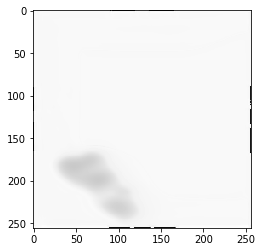

In [37]:
outputs = testing(5)

In [38]:
y = torch.from_numpy(test_Y[5].reshape((6, 1, 1, 256, 256))).type(torch.FloatTensor).to(device)
label = tensor_to_array(y)

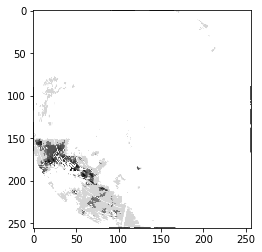

In [39]:
save_img_from_disk('labels', label)